In [2]:
!pip install transformers -q
!pip install sentencepiece -q

In [3]:
# # Mount Google drive to upload datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# The path to the data on my drive
D = '/content/drive/My Drive/W266_Project_Data/pmi_data'

In [5]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import copy
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch import optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Load the paraphrase training, dev, and test sets previously created in the last run
paraphrase_train = pd.read_csv(D+"/xml/amrita-paraphrase-exact/paraphrase_train_w_punjabi.csv")
paraphrase_train.drop(columns={"Unnamed: 0"}, inplace=True)

paraphrase_dev = pd.read_csv(D+"/xml/amrita-paraphrase-exact/paraphrase_dev_w_punjabi.csv")
paraphrase_dev.drop(columns={"Unnamed: 0"}, inplace=True)

paraphrase_test = pd.read_csv(D+"/xml/amrita-paraphrase-exact/paraphrase_test_w_punjabi.csv")
paraphrase_test.drop(columns={"Unnamed: 0"}, inplace=True)

In [7]:
# Filter the train, dev, and test datasets to filter by language origin (Aryan vs Dravidian)
aryan_train = paraphrase_train[(paraphrase_train.language_task == 'translate English to Hindi') | (paraphrase_train.language_task == 'translate English to Punjabi')]
aryan_dev = paraphrase_dev[(paraphrase_dev.language_task == 'translate English to Hindi') | (paraphrase_dev.language_task == 'translate English to Punjabi')]
aryan_test = paraphrase_test[(paraphrase_test.language_task == 'translate English to Hindi') | (paraphrase_test.language_task == 'translate English to Punjabi')]

drav_train = paraphrase_train[(paraphrase_train.language_task == 'translate English to Tamil') | (paraphrase_train.language_task == 'translate English to Malayalam')]
drav_dev = paraphrase_dev[(paraphrase_dev.language_task == 'translate English to Tamil') | (paraphrase_dev.language_task == 'translate English to Malayalam')]
drav_test = paraphrase_test[(paraphrase_test.language_task == 'translate English to Tamil') | (paraphrase_test.language_task == 'translate English to Malayalam')]

In [8]:
# Set up the device to run on GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
# Create an instance of the tokenizer and model using Indic Bert
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert', keep_accents=True)
model = AutoModel.from_pretrained('ai4bharat/indic-bert')

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'sop_classifier.classifier.weight', 'predictions.LayerNorm.bias', 'sop_classifier.classifier.bias', 'predictions.decoder.weight', 'predictions.dense.weight', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def sentence_embeddings(device, tokenizer, model, sentences):
  """Create contextualized sentence embeddings
  
  Parameters:
  tokenizer: transformers tokenizer for creating word tokens
  model:
  sentences: sentences to generate sentence embeddings for
  """

  # Tokenize sentences and return PyTorch tensors
  encoded_input = tokenizer(sentences, padding=True, truncation=True, 
                            max_length=128, return_tensors='pt')
  encoded_input = encoded_input.to(device)
  
  # Pass the tokenized input to the model 
  with torch.no_grad():
    model.to(device)
    model_output = model(**encoded_input) 
  
  # Perform mean pooling to get total sentence embeddings
  sentence_embeddings = mean_pooling(model_output, 
                                     encoded_input['attention_mask'])
  
  return sentence_embeddings

In [11]:
# An object to split and parse the training and test data fields
class SiameseNetworkDataset(Dataset): 
  def __init__(self,training_df, device, tokenizer, model):
    self.training_df=training_df
    self.sent1 = self.training_df['sentence_1'].tolist()
    self.sent2 = self.training_df['sentence_2'].tolist()
    self.language_task = self.training_df['language_task'].tolist()
    self.label = self.training_df['label'].tolist()
    self.device = device
    self.tokenizer = tokenizer
    self.model = model

  def __getitem__(self, index):
    sent1 = self.sent1[index]
    sent2 = self.sent2[index]
    task = self.language_task[index]
    label = self.label[index]

    # Get the sentence embeddings for sentences 1 and 2 for each row
    sent1_embeddings = sentence_embeddings(self.device, self.tokenizer, self.model, sent1)
    sent2_embeddings = sentence_embeddings(self.device, self.tokenizer, self.model, sent2)
    return sent1_embeddings, sent2_embeddings, task, torch.from_numpy(np.array(label)).long()

  def __len__(self):
    return len(self.training_df)

In [12]:
# Create separate instances of the Siamese Network dataset class using training, dev, and testing data for the Aryan languages
aryan_siamese_train = SiameseNetworkDataset(aryan_train, device, tokenizer, model)
aryan_siamese_dev = SiameseNetworkDataset(aryan_dev, device, tokenizer, model)
aryan_siamese_test = SiameseNetworkDataset(aryan_test, device, tokenizer, model)

In [13]:
# Create separate instances of the Siamese Network dataset class using training, dev, and testing data for the Dravidian languages
drav_siamese_train = SiameseNetworkDataset(drav_train, device, tokenizer, model)
drav_siamese_dev = SiameseNetworkDataset(drav_dev, device, tokenizer, model)
drav_siamese_test = SiameseNetworkDataset(drav_test, device, tokenizer, model)

In [14]:
# Get the label for every row in the training dataset and convert it to tensor form
aryan_target_list = []

for sent1, sent2, task, label in aryan_siamese_train:
  aryan_target_list.append(label)

# Store the torch form of the target label   
aryan_target_list = torch.tensor(aryan_target_list)

In [15]:
# Get the label for every row in the training dataset and convert it to tensor form
drav_target_list = []

for sent1, sent2, task, label in drav_siamese_train:
  drav_target_list.append(label)

# Store the torch form of the target label   
drav_target_list = torch.tensor(drav_target_list)

In [16]:
# Weight the labels by their frequency in the dataset - this will help our accuracy if there is an imbalance in classes (P vs NP)
aryan_class_count = [len(aryan_train[aryan_train.label == 0]),len(aryan_train[aryan_train.label == 1])]
print(aryan_class_count)
aryan_class_weights = 1./torch.tensor(aryan_class_count, dtype=torch.float) 
print(aryan_class_weights)

[2500, 1700]
tensor([0.0004, 0.0006])


In [17]:
# Weight the labels by their frequency in the dataset - this will help our accuracy if there is an imbalance in classes (P vs NP)
drav_class_count = [len(drav_train[drav_train.label == 0]),len(drav_train[drav_train.label == 1])]
print(drav_class_count)
drav_class_weights = 1./torch.tensor(drav_class_count, dtype=torch.float) 
print(drav_class_weights)

[3000, 2000]
tensor([0.0003, 0.0005])


In [18]:
# Create a list of the weighted labels to pass to the dataloader objects
aryan_class_weights_all = aryan_class_weights[aryan_target_list]
drav_class_weights_all = drav_class_weights[drav_target_list]

In [19]:
# Create the weighted sampler object to pass to the training data loader
aryan_weighted_sampler = WeightedRandomSampler(
    weights=aryan_class_weights_all,
    num_samples=len(aryan_class_weights_all),
    replacement=True
)
drav_weighted_sampler = WeightedRandomSampler(
    weights=drav_class_weights_all,
    num_samples=len(drav_class_weights_all),
    replacement=True
)

In [20]:
# Pass the training data into the training loader 
# Don't shuffle since we pre-shuffled the data - we want to see how the model performs on specific languages
aryan_train_loader = DataLoader(aryan_siamese_train, batch_size = 16, sampler=aryan_weighted_sampler)

# Create the dev and test data loaders
aryan_val_loader = DataLoader(aryan_siamese_dev, batch_size=16)
aryan_test_loader = DataLoader(aryan_siamese_test, batch_size=16)

In [21]:
# Pass the training data into the training loader 
# Don't shuffle since we pre-shuffled the data - we want to see how the model performs on specific languages
drav_train_loader = DataLoader(drav_siamese_train, batch_size = 16, sampler=drav_weighted_sampler)

# Create the dev and test data loaders
drav_val_loader = DataLoader(drav_siamese_dev, batch_size=16)
drav_test_loader = DataLoader(drav_siamese_test, batch_size=16)

In [22]:
class SiameseNet(torch.nn.Module):
    def __init__(self):
      super(SiameseNet, self).__init__()

      # Set up a fully-connected layer to apply to each incoming sentence vector
      # Use a dense layer (nn.Linear) to reduce the dimensionality of the input embeddings
      # use a relu activation function
      # Randomly drop out
      # Set 1 as the dimensionality of the final output since we want to predict the logits corresponding to a binary label
      # Initialize the feed forward layer
      self.fc = torch.nn.Sequential(
            torch.nn.Linear(768, 128),
            torch.nn.InstanceNorm1d(128),
            torch.nn.ReLU(inplace=True))
      
      self.relu = torch.nn.ReLU(inplace=True)
      self.batch2 = torch.nn.InstanceNorm1d(384)
      self.ffn = torch.nn.Linear(384, 128)
      self.batch3 = torch.nn.InstanceNorm1d(128)
      self.layer_out = torch.nn.Linear(128,1)

      # Add drop out
      self.drop = torch.nn.Dropout(0.2)

    # left and right represent columns in our data
    def forward(self, left, right):

      # Get the sentence embeddings 
      u = left
      v = right

      # Reduce the dimensionality
      u = self.fc(u)
      v = self.fc(v)

      # Get the absolute value of the difference of the vectors
      uv = torch.sub(u, v)
      uv_abs = torch.abs(uv)

      # concatenate u, v, and the absolute value of the element-wise difference between the embeddings
      x = torch.cat([u, v, uv_abs], dim=-1)

      # Normalize the concatenated batch
      x = self.batch2(x)

      # Use the relu activation function
      x = self.relu(x)

      # Pass the concatenated layers through a dense layer to reduce the dimensionality from 2304 to 128
      x = self.ffn(x)
      # Normalize the concatenated layers
      x = self.batch3(x)
      # Pass through relu activation
      x = self.relu(x)
      # Implement drop out to avoid overfitting
      x = self.drop(x)
      # Pass the output through a final dense layer
      output = self.layer_out(x)
      # Reshape the output to have the same dimension as the target labels
      output = output[:,-1,:]

      # Concatenate the 
      return output

In [23]:
# Create an instance of the Siamese model network
# Declare Siamese Network
aryan_net = SiameseNet().to(device)
drav_net = SiameseNet().to(device)

# Set the criteria for evaluation and training - use cross-entropy since we're doing classification and want to retrieve the labels
criterion = torch.nn.BCEWithLogitsLoss()

# Set the optimizer and pass to it the model parameters and learning rate
aryan_optimizer = optim.Adam(aryan_net.parameters(), lr=2e-5)
drav_optimizer = optim.Adam(drav_net.parameters(), lr=2e-5)

In [24]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [25]:
# Create dictionaries to hold the training and validation accuracy and loss metrics at each epoch
aryan_epoch_accuracies = {
    'train': [],
    "val": []}

aryan_epoch_losses = {
    'train': [],
    "val": []}

drav_epoch_accuracies = {
    'train': [],
    "val": []}

drav_epoch_losses = {
    'train': [],
    "val": []}

In [26]:
EPOCHS = 10

for e in tqdm(range(1, EPOCHS+1)):
    
    # Initialize the training epoch and accuracy loss as 0
    train_epoch_loss = 0
    train_epoch_acc = 0

    # Place the Siamese network into training mode
    aryan_net.train()
    
    # Loop over records in the training data loader
    for i, data in enumerate(aryan_train_loader, 0):
      sent1, sent2, task, label = data
      label = label.type(torch.FloatTensor).reshape((label.shape[0], 1))
      # Send the training data to GPU
      sent1, sent2, label = sent1.to(device), sent2.to(device), label.to(device)
      # Zero the gradient
      aryan_optimizer.zero_grad()
      # Get the predicted softmaxes
      train_pred = aryan_net(sent1, sent2)
      # Get the predicted labels
      train_loss = criterion(train_pred, label)
      # Find the training rate accuracy
      train_acc = binary_acc(train_pred, label)
      
      train_loss.backward()
      aryan_optimizer.step()

      # Update the loss and accuracy for the current epoch  
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()   
        
    # Enter validation phase   
    with torch.no_grad():
        
        # Initialize the validation loss and accuracy rates as 0
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        # Place the model into evaluation mode
        aryan_net.eval()

        # Loop over records in the validation dataloader
        for i, data in enumerate(aryan_val_loader, 0):
          sent1_val, sent2_val, task_val, label_val = data
          label_val = label_val.type(torch.FloatTensor).reshape((label_val.shape[0], 1))

          # Send the validation data to GPU
          sent1_val, sent2_val, label_val = sent1_val.to(device), sent2_val.to(device), label_val.to(device)

          # Get the validation predictions          
          val_pred = aryan_net(sent1_val, sent2_val)
          # Find the validation loss and accuracy
          val_loss = criterion(val_pred, label_val)
          val_acc = binary_acc(val_pred, label_val)
          
          # Update the validation loss and accuracy rates
          val_epoch_loss += val_loss.item()
          val_epoch_acc += val_acc.item()
    
    # Store the epoch's training and validaion accuracies and losses
    aryan_epoch_losses['train'].append(train_epoch_loss/len(aryan_train_loader))
    aryan_epoch_losses['val'].append(val_epoch_loss/len(aryan_val_loader))
    aryan_epoch_accuracies['train'].append(train_epoch_acc/len(aryan_train_loader))
    aryan_epoch_accuracies['val'].append(val_epoch_acc/len(aryan_val_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
aryan_epoch_accuracies

{'train': [63.87832699619772,
  79.20912547528518,
  87.12167300380229,
  88.41444866920152,
  92.1787072243346,
  93.19011406844106,
  95.19391634980988,
  93.98479087452472,
  95.49429657794677,
  96.79087452471482],
 'val': [78.72727272727273,
  85.22727272727273,
  86.3409090909091,
  89.36363636363636,
  89.1590909090909,
  89.43181818181819,
  88.4090909090909,
  89.56818181818181,
  88.8409090909091,
  89.56818181818181]}

In [28]:
aryan_epoch_losses

{'train': [0.6528104297788424,
  0.5418324584970002,
  0.4474607591619963,
  0.3911187848210788,
  0.3211373504350394,
  0.28414964409608806,
  0.24029473733765996,
  0.23351565034557203,
  0.19983704878236858,
  0.17244279806718174],
 'val': [0.5839884315024723,
  0.46976830674843356,
  0.4068772057917985,
  0.3549658859317953,
  0.3258923143148422,
  0.3018772986463525,
  0.2912916717204181,
  0.2730323447083885,
  0.27623415958474984,
  0.2565537321973931]}

In [29]:
EPOCHS = 10

for e in tqdm(range(1, EPOCHS+1)):
    
    # Initialize the training epoch and accuracy loss as 0
    train_epoch_loss = 0
    train_epoch_acc = 0

    # Place the Siamese network into training mode
    drav_net.train()
    
    # Loop over records in the training data loader
    for i, data in enumerate(drav_train_loader, 0):
      sent1, sent2, task, label = data
      label = label.type(torch.FloatTensor).reshape((label.shape[0], 1))
      # Send the training data to GPU
      sent1, sent2, label = sent1.to(device), sent2.to(device), label.to(device)
      # Zero the gradient
      drav_optimizer.zero_grad()
      # Get the predicted softmaxes
      train_pred = drav_net(sent1, sent2)
      # Get the predicted labels
      train_loss = criterion(train_pred, label)
      # Find the training rate accuracy
      train_acc = binary_acc(train_pred, label)
      
      train_loss.backward()
      drav_optimizer.step()

      # Update the loss and accuracy for the current epoch  
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()   
        
    # Enter validation phase   
    with torch.no_grad():
        
        # Initialize the validation loss and accuracy rates as 0
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        # Place the model into evaluation mode
        drav_net.eval()

        # Loop over records in the validation dataloader
        for i, data in enumerate(drav_val_loader, 0):
          sent1_val, sent2_val, task_val, label_val = data
          label_val = label_val.type(torch.FloatTensor).reshape((label_val.shape[0], 1))

          # Send the validation data to GPU
          sent1_val, sent2_val, label_val = sent1_val.to(device), sent2_val.to(device), label_val.to(device)

          # Get the validation predictions          
          val_pred = drav_net(sent1_val, sent2_val)
          # Find the validation loss and accuracy
          val_loss = criterion(val_pred, label_val)
          val_acc = binary_acc(val_pred, label_val)
          
          # Update the validation loss and accuracy rates
          val_epoch_loss += val_loss.item()
          val_epoch_acc += val_acc.item()
    
    # Store the epoch's training and validaion accuracies and losses
    drav_epoch_losses['train'].append(train_epoch_loss/len(drav_train_loader))
    drav_epoch_losses['val'].append(val_epoch_loss/len(drav_val_loader))
    drav_epoch_accuracies['train'].append(train_epoch_acc/len(drav_train_loader))
    drav_epoch_accuracies['val'].append(val_epoch_acc/len(drav_val_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

In [30]:
drav_epoch_accuracies

{'train': [58.067092651757186,
  69.07987220447285,
  73.77316293929712,
  77.49201277955271,
  79.85303514376997,
  80.6773162939297,
  83.37699680511182,
  83.99041533546325,
  86.21086261980831,
  87.30670926517571],
 'val': [58.10526315789474,
  64.29824561403508,
  65.87719298245614,
  65.43859649122807,
  67.3157894736842,
  67.57894736842105,
  68.47368421052632,
  67.0701754385965,
  69.75438596491227,
  69.9298245614035]}

In [31]:
drav_epoch_losses

{'train': [0.6702825922173814,
  0.6019493949870331,
  0.5512109382655292,
  0.504703692925243,
  0.46797322731810254,
  0.4491283719341595,
  0.4149217975501435,
  0.39449481232859457,
  0.37061310957034177,
  0.3558749203769544],
 'val': [0.6769672715873049,
  0.6391475875126688,
  0.6318335627254686,
  0.6331167942599246,
  0.6315908803228747,
  0.6371906880746808,
  0.6270157809843097,
  0.6551989876387412,
  0.620071397015923,
  0.6169981208809635]}

In [32]:
print(max(aryan_epoch_accuracies.get('train')))
print(max(aryan_epoch_accuracies.get('val')))

print(max(drav_epoch_accuracies.get('train')))
print(max(drav_epoch_accuracies.get('val')))

96.79087452471482
89.56818181818181
87.30670926517571
69.9298245614035


In [33]:
print(min(aryan_epoch_accuracies.get('train')))
print(min(aryan_epoch_accuracies.get('val')))

print(min(drav_epoch_accuracies.get('train')))
print(min(drav_epoch_accuracies.get('val')))

63.87832699619772
78.72727272727273
58.067092651757186
58.10526315789474


In [34]:
print(min(aryan_epoch_losses.get('train')))
print(max(aryan_epoch_losses.get('train')))

print(min(drav_epoch_losses.get('train')))
print(max(drav_epoch_losses.get('train')))

0.17244279806718174
0.6528104297788424
0.3558749203769544
0.6702825922173814


In [35]:
print(min(aryan_epoch_losses.get('val')))
print(max(aryan_epoch_losses.get('val')))

print(min(drav_epoch_losses.get('val')))
print(max(drav_epoch_losses.get('val')))

0.2565537321973931
0.5839884315024723
0.6169981208809635
0.6769672715873049


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

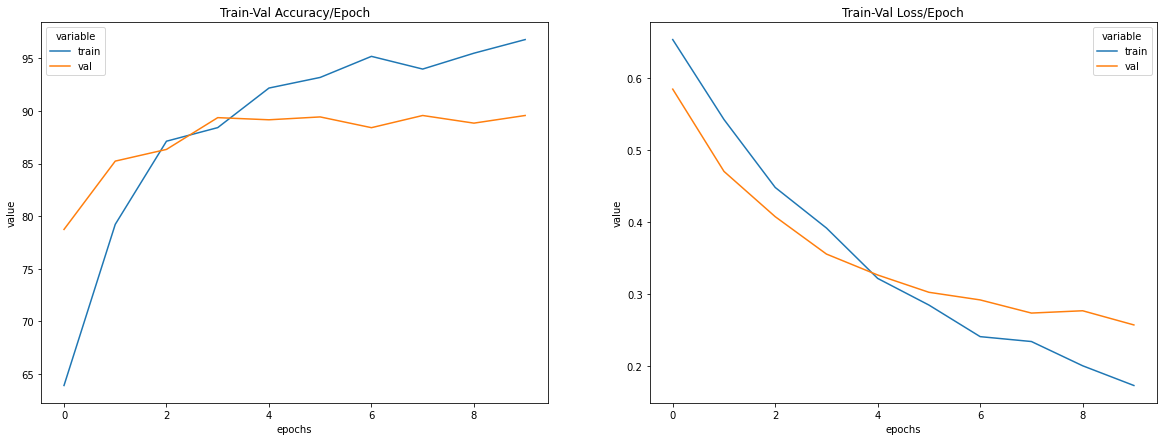

In [36]:
# Create dataframes from the average training accuracy and loss 
train_val_acc_df = pd.DataFrame.from_dict(aryan_epoch_accuracies).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(aryan_epoch_losses).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

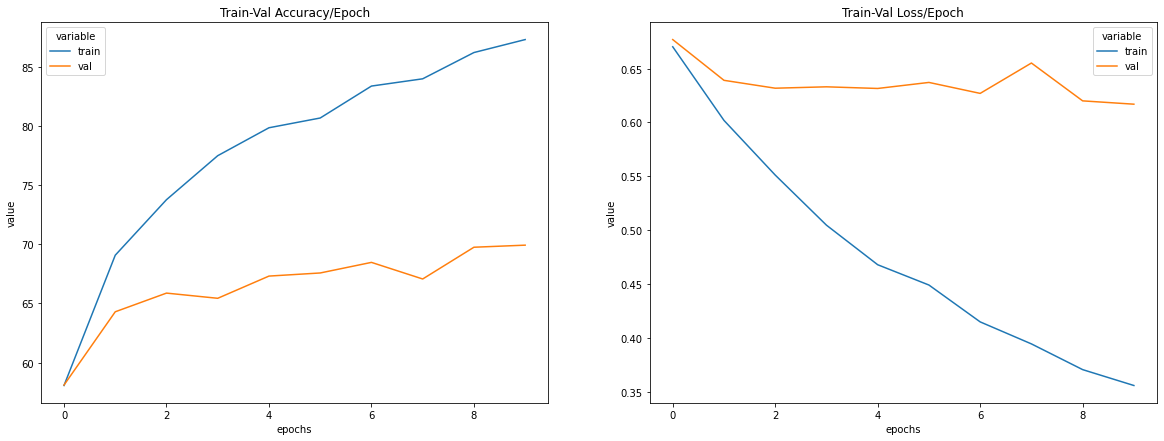

In [37]:
# Create dataframes from the average training accuracy and loss 
train_val_acc_df = pd.DataFrame.from_dict(drav_epoch_accuracies).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(drav_epoch_losses).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [38]:
# Get the test accuracy and labels
aryan_sent1 = aryan_test.sentence_1.tolist()
aryan_sent2 = aryan_test.sentence_2.tolist()
aryan_y_pred_list = []
aryan_y_actual_list = []
aryan_y_language_task = []

with torch.no_grad():

  # Place the model into evaluation mode
    aryan_net.eval()

    # Loop over the test set
    for i, data in enumerate(aryan_test_loader, 0):

      # Extract the test set components
      sent1_test, sent2_test, task_test, label_test = data

      # Store the language tasks and actual labels to check model performance
      aryan_y_actual_list.extend(label_test.tolist())
      aryan_y_language_task.extend(task_test)

      # Reshape the test label to have the same dimensions as the model output
      label_test = label_test.type(torch.FloatTensor).reshape((label_test.shape[0], 1))

      # Send the test data to GPU
      sent1_test, sent2_test, label_test = sent1_test.to(device), sent2_test.to(device), label_test.to(device)

      # Get the test set predictions
      test_pred = aryan_net(sent1_test, sent2_test)
            
      # Get the predicted test labels
      y_test_pred = torch.round(torch.sigmoid(test_pred)).long()

      # Add the test labels to their respective list
      aryan_y_pred_list.extend(y_test_pred)

In [39]:
# Create a dataframe from test performance
aryan_y_pred = [x.item() for x in aryan_y_pred_list]
aryan_test_performance = pd.DataFrame(list(zip(aryan_y_language_task, aryan_sent1, aryan_sent2, aryan_y_actual_list, aryan_y_pred)),columns =['language', 'sentence_1', 'sentence_2', 'actual_label', 'predicted_label'])

In [40]:
aryan_test_performance

,language,sentence_1,sentence_2,actual_label,predicted_label
0,translate English to Hindi,1984 में बारामती से उन्होंने पहली बार लोकसभा च...,बारामती से 1984 में उन्होंने पहली बार लोकसभा ...,1,1
1,translate English to Hindi,सुप्रीम कोर्ट की फटकार के बाद भी आजम अपने बयान...,सरकार का फर्ज बनता है कि लगातार हो रही एक जैस...,0,0
2,translate English to Hindi,"उत्तराखंड में जारी रहेगा राष्ट्रपति शासन, हाई...",उत्तराखण्ड में राष्ट्रपति शासन हटाने के नैनीता...,1,1
3,translate English to Hindi,भारत ने पृथ्वी-दो मिसाइल का किया सफल प्रक्षेपण,भारत ने आज परमाणु क्षमता संपन्न और स्वदेश में ...,1,1
4,translate English to Hindi,मीडिया रिपोर्ट्स में ये जानकारी नहीं है कि फा...,फाइनेंशियल मदद के तौर पर कितना अमाउंट दिया गय...,1,1
...,...,...,...,...,...
695,translate English to Punjabi,ਉਂਜ ਹਰ ਡਿਪੂ ਨੂੰ ਘੱਟੋ-ਘੱਟ 25 ਨਵੀਆਂ ਬੱਸਾਂ ਦਿੱਤੀ...,ਉਂਜ ਘੱਟੋ-ਘੱਟ 25 ਨਵੀਆਂ ਬੱਸਾਂ ਹਰ ਡਿਪੂ ਨੂੰ ਦਿੱਤੀਆ...,1,1
696,translate English to Punjabi,ਇਨ੍ਹਾਂ ਵਿੱਚ 241 ਰਾਜਨੀਤੀ ਸ਼ਾਸਤਰ ਤੇ 170 ਇਤਿਹਾਸ ਦੇ...,170 ਇਤਿਹਾਸ ਦੇ ਅਤੇ 241 ਰਾਜਨੀਤੀ ਸ਼ਾਸਤਰ ਦੇ ਲੈਕਚਰਾ...,1,1
697,translate English to Punjabi,ਇਸਤੋਂ ਪਹਿਲਾਂ ਸ਼ੋਮਣੀ ਅਕਾਲੀ ਦਲ ਦੇ ਇਤਿਹਾਸ ਤੇ ਪਿਛਲੇ...,ਪਹਿਲਾਂ ਇਹ ਵੈੱਬਸਾਈਟ ਸਰਬੱਤ ਖ਼ਾਲਸਾ ਦੀ ਚੱਲ ਰਹੀ ਸੀ|,0,0
698,translate English to Punjabi,"ਟਾਸਕ ਫੋਰਸ ਖੇਡ ਸਹੂਲਤਾਂ, ਸਿਖਲਾਈ, ਚੋਣ ਅਮਲ ਤੇ ਇਨ੍ਹ...","ਖੇਡ ਸਹੂਲਤਾਂ, ਸਿਖਲਾਈ, ਚੋਣ ਅਮਲ ਤੇ ਇਨ੍ਹਾਂ ਨਾਲ ਸਬੰ...",1,1


In [83]:
# Get the test accuracy and labels
drav_sent1 = drav_test.sentence_1.tolist()
drav_sent2 = drav_test.sentence_2.tolist()
drav_y_pred_list = []
drav_y_actual_list = []
drav_y_language_task = []

with torch.no_grad():

  # Place the model into evaluation mode
    drav_net.eval()

    # Loop over the test set
    for i, data in enumerate(drav_test_loader, 0):

      # Extract the test set components
      sent1_test, sent2_test, task_test, label_test = data

      # Store the language tasks and actual labels to check model performance
      drav_y_actual_list.extend(label_test.tolist())
      drav_y_language_task.extend(task_test)

      # Reshape the test label to have the same dimensions as the model output
      label_test = label_test.type(torch.FloatTensor).reshape((label_test.shape[0], 1))

      # Send the test data to GPU
      sent1_test, sent2_test, label_test = sent1_test.to(device), sent2_test.to(device), label_test.to(device)

      # Get the test set predictions
      test_pred = drav_net(sent1_test, sent2_test)
            
      # Get the predicted test labels
      y_test_pred = torch.round(torch.sigmoid(test_pred)).long()

      # Add the test labels to their respective list
      drav_y_pred_list.extend(y_test_pred)

In [87]:
# Create a dataframe from test performance
drav_y_pred = [x.item() for x in drav_y_pred_list]
drav_test_performance = pd.DataFrame(list(zip(drav_y_language_task, drav_sent1, drav_sent2, drav_y_actual_list)),columns =['language', 'sentence_1', 'sentence_2', 'actual_label'])

In [88]:
drav_test_performance = pd.concat([drav_test_performance, pd.DataFrame(drav_y_pred)], axis=1)
drav_test_performance.rename(columns = {0: 'predicted_label'}, inplace=True)

In [89]:
# Creating a separate Dravididan model results in the loss of all predictions for Tamil
print(drav_test_performance[drav_test_performance.language == 'translate English to Tamil'].predicted_label.isna().sum())
print(drav_test_performance[drav_test_performance.language == 'translate English to Tamil'].predicted_label.notna().sum())

# And a loss of predictions for some of the Malayalam sentences
print(drav_test_performance[drav_test_performance.language == 'tranlsate English to Malayalam'].predicted_label.isna().sum())
print(drav_test_performance[drav_test_performance.language == 'translate English to Malayalam'].predicted_label.notna().sum())

0
450
0
450


In [91]:
# Save the file to share
aryan_test_performance.to_csv(D+"/predicted_text/siamese_evaluations_of_translations/aryan_test.csv")
drav_test_performance.to_csv(D+"/predicted_text/siamese_evaluations_of_translations/drav_test.csv")

In [92]:
# Accuracy for the Aryan languages is approximately 96% - not better than an 
print(accuracy_score(aryan_y_actual_list, aryan_y_pred))

0.9157142857142857


In [94]:
drav_test.label.value_counts()

0    479
1    421
Name: label, dtype: int64

In [95]:
print(accuracy_score(drav_y_actual_list, drav_y_pred))

0.6688888888888889


In [96]:
# Get the overall f1-score
print(f1_score(aryan_y_actual_list, aryan_y_pred))
print(f1_score(drav_y_actual_list, drav_y_pred))

0.9110105580693816
0.6078947368421053


In [97]:
# Get the accuracy scores on Hindi
hi_test = aryan_test_performance[aryan_test_performance.language == 'translate English to Hindi']
# The model performs very well on Hindi
print(accuracy_score(hi_test.actual_label.tolist(), hi_test.predicted_label.tolist()))
# Get the f1-score
print(f1_score(hi_test.actual_label.tolist(), hi_test.predicted_label.tolist()))

0.8822222222222222
0.8710462287104623


In [98]:
# Get the accuracy scores on Tamil for the records where a label was predicted
ta_test = drav_test_performance[(drav_test_performance.language == 'translate English to Tamil') & (drav_test_performance.predicted_label.notna())]
# The model performs very well on Hindi
print(accuracy_score(ta_test.actual_label.tolist(), ta_test.predicted_label.tolist()))
# Get the f1-score
print(f1_score(ta_test.actual_label.tolist(), ta_test.predicted_label.tolist()))

0.5866666666666667
0.425925925925926


In [99]:
# Get the accuracy scores on Malayalam
ml_test = drav_test_performance[drav_test_performance.language == 'translate English to Malayalam']
# The model performs very well on Hindi
print(accuracy_score(ml_test.actual_label.tolist(), ml_test.predicted_label.tolist()))
# Get the f1-score
print(f1_score(ml_test.actual_label.tolist(), ml_test.predicted_label.tolist()))

0.7511111111111111
0.7431192660550459


In [100]:
# Get the accuracy scores on Punjabi
pb_test = aryan_test_performance[aryan_test_performance.language == 'translate English to Punjabi']
# The model performs very well on Hindi
print(accuracy_score(pb_test.actual_label.tolist(), pb_test.predicted_label.tolist()))
# Get the f1-score
print(f1_score(pb_test.actual_label.tolist(), pb_test.predicted_label.tolist()))

0.976
0.976190476190476


In [102]:
# Let's see the number of mistakes the model is making (on what language tasks)
aryan_cm = confusion_matrix(aryan_y_actual_list, aryan_y_pred)
drav_cm = confusion_matrix(drav_y_actual_list, drav_y_pred)

# Create and apply a mask to ignore the diagonal entries (these are correctly predicted values)
print(aryan_cm, "\n")
print(drav_cm)

[[339  40]
 [ 19 302]] 

[[371 108]
 [190 231]]


In [103]:
# Check the confusiom matrix on Hindi
confusion_matrix(hi_test.actual_label.tolist(), hi_test.predicted_label.tolist())

array([[218,  36],
       [ 17, 179]])

In [104]:
# Check the confusiom matrix on Tamil
confusion_matrix(ta_test.actual_label.tolist(), ta_test.predicted_label.tolist())

array([[195,  53],
       [133,  69]])

In [105]:
# Check the confusiom matrix on Malayalam
confusion_matrix(ml_test.actual_label.tolist(), ml_test.predicted_label.tolist())

array([[176,  55],
       [ 57, 162]])

In [106]:
# Check the confusiom matrix on Punjabi
confusion_matrix(pb_test.actual_label.tolist(), pb_test.predicted_label.tolist())

array([[121,   4],
       [  2, 123]])

In [107]:
# Save the weights and biases
torch.save(aryan_net.state_dict(), "/content/drive/My Drive/W266_Project_Data/models/siamese_model/aryan_model.pt")
torch.save(drav_net.state_dict(), "/content/drive/My Drive/W266_Project_Data/models/siamese_model/drav_model.pt")

print("Model Saved")

Model Saved
